# OCR Preprocessing Pipeline for Renaissance Documents

This notebook randomly samples pages from a set of PDF documents, converts them to images, and applies a standard OCR preprocessing pipeline:
- Grayscale conversion
- Noise removal (median filter)
- Binarization (Otsu’s threshold)
- Deskewing

You'll end up with clean, black-and-white PNG files ready for OCR.



### 1. Install Dependencies

Run the following cell to install necessary packages (requires Poppler installed on your system):


In [7]:

%pip install pdf2image opencv-python numpy gdown ipywidgets matplotlib opencv-python-headless

  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\katej\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------- ----------- 1.6/2.2 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   - -------------------------------------- 1.8/38.9 MB 8.4 MB/s eta 0:00:05
   --- ------------------------------------ 3.4/38.9 MB 8.4 MB/s eta 0:00:05
   ----- ---------------------------------- 5.5/38.9 MB 8.6 MB/s eta 0:00:04
   -------- ------------------------------- 7.9/38.9 MB 9.6 MB/s eta 0:00:04
   ---------- ----------------------------- 10.5/38.9 MB 9.9 MB/s eta 0:00:03
   ------------- -------------------------- 12.8/38.9 MB 10.2 MB/s eta 0:00:03
   --------------- ------------------------ 15.5/38.9 MB 10.6 MB/s eta 0:00:03
   ------------------ --------------------- 18.1/38.9 MB 10.7 MB/s eta 0:00:02
   --------------


### 2. Imports and Configuration

Adjust the paths below to point to your PDF directory and desired output folder.

In [ ]:
import os
import random
from pdf2image import convert_from_path, pdfinfo_from_path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Disable PIL bomb check
Image.MAX_IMAGE_PIXELS = None

# Configuration
pdf_dir = '/data/pdfs'
pdf_samples_dir = '/data/pdf_samples'
png_dir = '/data/pngs'
processed_dir = '/data/processed_data'
processed_resized_dir = '/data/processed_resized'
POPPLER_PATH = 'C:/Users/katej/OneDrive/Documents/Downloads/Release-24.08.0-0/poppler-24.08.0/Library/bin/'
# Update to your own path

os.makedirs(processed_dir, exist_ok=True)

# Set DPI for conversion
DPI = 300

# Number of documents and pages to sample
NUM_DOCUMENTS = 5
PAGES_PER_DOC = 5

#### Download DataSets from Google Drive Folder

In [5]:
folder_id = "1B_dM138pLrQGxRqUn1wcFO2MEotGWr7h"
gdown_command = f"gdown --folder {folder_id} -O {pdf_dir}"
print('Running:', gdown_command)
!{gdown_command}


Running: gdown --folder 1B_dM138pLrQGxRqUn1wcFO2MEotGWr7h -O /data/pdfs
^C



### 3. Sampling PDFs and Pages, and Converting to PNG

This cell selects `NUM_DOCUMENTS` random PDFs and then samples up to `PAGES_PER_DOC` pages from each.

In [6]:
import os
import random
from pathlib import Path
from pdf2image import pdfinfo_from_path, convert_from_path
from pdf2image.exceptions import PDFPopplerTimeoutError
import shutil

if os.path.exists(png_dir):
    shutil.rmtree(png_dir)
os.makedirs(png_dir, exist_ok=True)

Path(png_dir).mkdir(exist_ok=True)

print("PDF dir exists?", os.path.exists(pdf_dir))
print("PDF dir contents:", os.listdir(pdf_dir))

for pdf in sorted(os.listdir(pdf_dir)):
    if not pdf.lower().endswith('.pdf'):
        continue
    pdf_path = os.path.join(pdf_dir, pdf)
    try:
        info = pdfinfo_from_path(pdf_path, poppler_path=POPPLER_PATH)
    except Exception as e:
        print(f"Skipping invalid PDF '{pdf}': {e}")
        continue

    total = info['Pages']
    pages = random.sample(range(1, total+1), min(PAGES_PER_DOC, total))

    for pg in pages:
        try:
            pil = convert_from_path(
                pdf_path,
                dpi=DPI,
                poppler_path=POPPLER_PATH,
                first_page=pg,
                last_page=pg,
                fmt='png',
                use_pdftocairo=True,
                thread_count=1,
                timeout=90
            )[0]
        except PDFPopplerTimeoutError:
            print(f"Timed out converting {pdf} page {pg}")
            continue
        except Exception as e:
            print(f"Error converting {pdf} page {pg}: {e}")
            continue

        base = os.path.splitext(pdf)[0]
        out_name = f"{base}_p{pg:03d}.png"
        out_path = os.path.join(png_dir, out_name)
        pil.save(out_path, format='PNG')
        print("Saved:", out_path)



PDF dir exists? True
PDF dir contents: ['Ayala, Lorenzo de. Valladolid 1603.pdf', 'Burgos, Juan de. Valladolid 1500.pdf', 'Burgos, Juan de. Valladolid 1500.pdfakcimy66.part', 'Burgos, Juan de. Valladolid 1500.pdfnz96fwax.part', 'Cansoles, Fernando. Mallorca 1541.pdf', 'Cerda - Estados mujeres OG BW.pdf', 'Cerda - Estados mujeres OG BW.pdfrx1y_rde.part', 'Guevara - Reloj de Principes OG.pdf', 'Guevara - Reloj de Principes OG.pdfuxsqvl75.part']
Saved: data/pngs\Ayala, Lorenzo de. Valladolid 1603_p008.png
Saved: data/pngs\Ayala, Lorenzo de. Valladolid 1603_p011.png
Saved: data/pngs\Ayala, Lorenzo de. Valladolid 1603_p009.png
Saved: data/pngs\Ayala, Lorenzo de. Valladolid 1603_p022.png
Saved: data/pngs\Ayala, Lorenzo de. Valladolid 1603_p019.png
Saved: data/pngs\Burgos, Juan de. Valladolid 1500_p011.png
Saved: data/pngs\Burgos, Juan de. Valladolid 1500_p021.png
Saved: data/pngs\Burgos, Juan de. Valladolid 1500_p004.png
Saved: data/pngs\Burgos, Juan de. Valladolid 1500_p002.png
Saved: data/


### 4. Preprocessing Pipeline Function

Defines a function to process a single image: grayscale, denoise, binarize, deskew.


In [3]:
class DocumentEnhancer:
    def __init__(self, min_area=50):
        self.min_area = min_area  # minimum connected-component area to keep

    def load_image(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Could not read image: {img_path}")
        return img

    def denoise(self, gray):
        # Fast Non-Local Means denoising
        return cv2.fastNlMeansDenoising(
            gray, None,
            h=10,
            templateWindowSize=7,
            searchWindowSize=21
        )

    def remove_background(self, gray):
        # Estimate and divide out the background
        bg = cv2.medianBlur(gray, 55)
        return cv2.divide(gray, bg, scale=255)

    def enhance_text(self, img):
        # CLAHE and contrast stretch
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img)
        lo, hi = np.percentile(enhanced, [2, 98])
        stretched = np.clip((enhanced - lo)*(255.0/(hi-lo)), 0, 255).astype(np.uint8)
        return stretched

    def binarize(self, img):
        # Inverted Otsu, then invert back to black text on white background
        _, bw_inv = cv2.threshold(
            img, 0, 255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
        bw = cv2.bitwise_not(bw_inv)
        # Remove small speckles
        kernel = np.ones((3,3), np.uint8)
        return cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel, iterations=1)

    def close_gaps(self, bw):
        # Fill small holes inside letters
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        return cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=1)

    def filter_components(self, bw):
        # Remove tiny connected components
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
        cleaned = np.zeros_like(bw)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= self.min_area:
                cleaned[labels == i] = 255
        return cleaned

    def preprocess(self, img_bgr):
        # 1. Grayscale
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        # 2. Denoise
        gray_dn = self.denoise(gray)
        # 3. Background removal
        bg_removed = self.remove_background(gray_dn)
        # 4. Text enhancement
        enhanced = self.enhance_text(bg_removed)
        # 5. Binarization
        bw = self.binarize(enhanced)
        # 6. Close gaps
        bw_closed = self.close_gaps(bw)
        # 7. Filter components
        bw_clean = self.filter_components(bw_closed)
        return bw_clean

#### Interactive Slider

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from pdf2image import convert_from_path
from PIL import Image
from pathlib import Path

# Poppler path (only needed on Windows)
POPPLER_PATH = 'C:/Users/katej/OneDrive/Documents/Downloads/Release-24.08.0-0/poppler-24.08.0/Library/bin/'
def load_pdf_page(pdf_path, page_num=1, dpi=300):
    pil = convert_from_path(
        pdf_path,
        dpi=dpi,
        first_page=page_num,
        last_page=page_num,
        poppler_path=POPPLER_PATH
    )[0]
    return np.array(pil)[:, :, ::-1]  # Convert to BGR for OpenCV

class DocumentEnhancer:
    def __init__(self, min_area=50, clahe_clip=3.0, blur_kernel=55, denoise_h=10):
        self.min_area = min_area
        self.clahe_clip = clahe_clip
        self.blur_kernel = blur_kernel
        self.denoise_h = denoise_h

    def preprocess(self, img_bgr):
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        gray_dn = cv2.fastNlMeansDenoising(gray, None, h=self.denoise_h, templateWindowSize=7, searchWindowSize=21)
        bg = cv2.medianBlur(gray_dn, self.blur_kernel)
        bg_removed = cv2.divide(gray_dn, bg, scale=255)

        clahe = cv2.createCLAHE(clipLimit=self.clahe_clip, tileGridSize=(8,8))
        enhanced = clahe.apply(bg_removed)

        lo, hi = np.percentile(enhanced, [2, 98])
        stretched = np.clip((enhanced - lo) * (255.0 / (hi - lo)), 0, 255).astype(np.uint8)

        _, bw_inv = cv2.threshold(stretched, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        bw = cv2.bitwise_not(bw_inv)
        closed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8))
        return self.filter_components(closed)

    def filter_components(self, bw):
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
        cleaned = np.zeros_like(bw)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= self.min_area:
                cleaned[labels == i] = 255
        return cleaned


In [10]:
def interactive_pdf_enhancer(pdf_path, page=1, dpi=300):
    img_bgr = load_pdf_page(pdf_path, page_num=page, dpi=dpi)

    @interact(
        min_area=IntSlider(min=10, max=500, step=10, value=50, description="Min Area"),
        clahe_clip=FloatSlider(min=1.0, max=10.0, step=0.5, value=3.0, description="CLAHE Clip"),
        blur_kernel=IntSlider(min=5, max=101, step=2, value=55, description="Blur Kernel"),
        denoise_h=IntSlider(min=0, max=30, step=1, value=10, description="Denoise H")
    )
    def update(min_area, clahe_clip, blur_kernel, denoise_h):
        enhancer = DocumentEnhancer(
            min_area=min_area,
            clahe_clip=clahe_clip,
            blur_kernel=blur_kernel,
            denoise_h=denoise_h
        )
        processed = enhancer.preprocess(img_bgr)

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.title("Original Page")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(processed, cmap='gray')
        plt.title("Enhanced Output")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [ ]:
interactive_pdf_enhancer("data/pdfs/Ayala, Lorenzo de. Valladolid 1603.pdf", page=1)


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "c:\Users\katej\AppData\Local\Programs\Python\Python39\python.exe"
  * The NumPy version is: "1.23.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.



### 5. Process and Save Sampled Pages

This cell converts pages to images, applies preprocessing, and writes PNGs to disk.


In [4]:
enhancer = DocumentEnhancer()
import shutil
import os

processed_dir = r"data/processed_data" 
png_dir = r"data/pngs"                

os.makedirs(processed_dir, exist_ok=True)

for png in sorted(os.listdir(png_dir)):
    if not png.lower().endswith('.png'):
        continue
    img_path = os.path.join(png_dir, png)
    img_bgr  = enhancer.load_image(img_path)
    if img_bgr is None:
        continue

    out = enhancer.preprocess(img_bgr)
    # Ensure output is 3-channel for saving as color PNG
    if out.ndim == 2:
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(os.path.join(processed_dir, png), out)
    print("Saved:", png)

Saved: Ayala, Lorenzo de. Valladolid 1603-01.png
Saved: Ayala, Lorenzo de. Valladolid 1603-02.png
Saved: Ayala, Lorenzo de. Valladolid 1603-03.png
Saved: Ayala, Lorenzo de. Valladolid 1603-04.png
Saved: Ayala, Lorenzo de. Valladolid 1603-05.png
Saved: Ayala, Lorenzo de. Valladolid 1603-06.png
Saved: Ayala, Lorenzo de. Valladolid 1603-07.png
Saved: Ayala, Lorenzo de. Valladolid 1603-08.png
Saved: Ayala, Lorenzo de. Valladolid 1603-09.png
Saved: Ayala, Lorenzo de. Valladolid 1603-10.png
Saved: Ayala, Lorenzo de. Valladolid 1603-11.png
Saved: Ayala, Lorenzo de. Valladolid 1603-12.png
Saved: Ayala, Lorenzo de. Valladolid 1603-13.png
Saved: Ayala, Lorenzo de. Valladolid 1603-14.png
Saved: Ayala, Lorenzo de. Valladolid 1603-15.png
Saved: Ayala, Lorenzo de. Valladolid 1603-16.png
Saved: Ayala, Lorenzo de. Valladolid 1603-17.png
Saved: Ayala, Lorenzo de. Valladolid 1603-18.png
Saved: Ayala, Lorenzo de. Valladolid 1603-19.png
Saved: Ayala, Lorenzo de. Valladolid 1603-20.png
Saved: Ayala, Lorenz

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


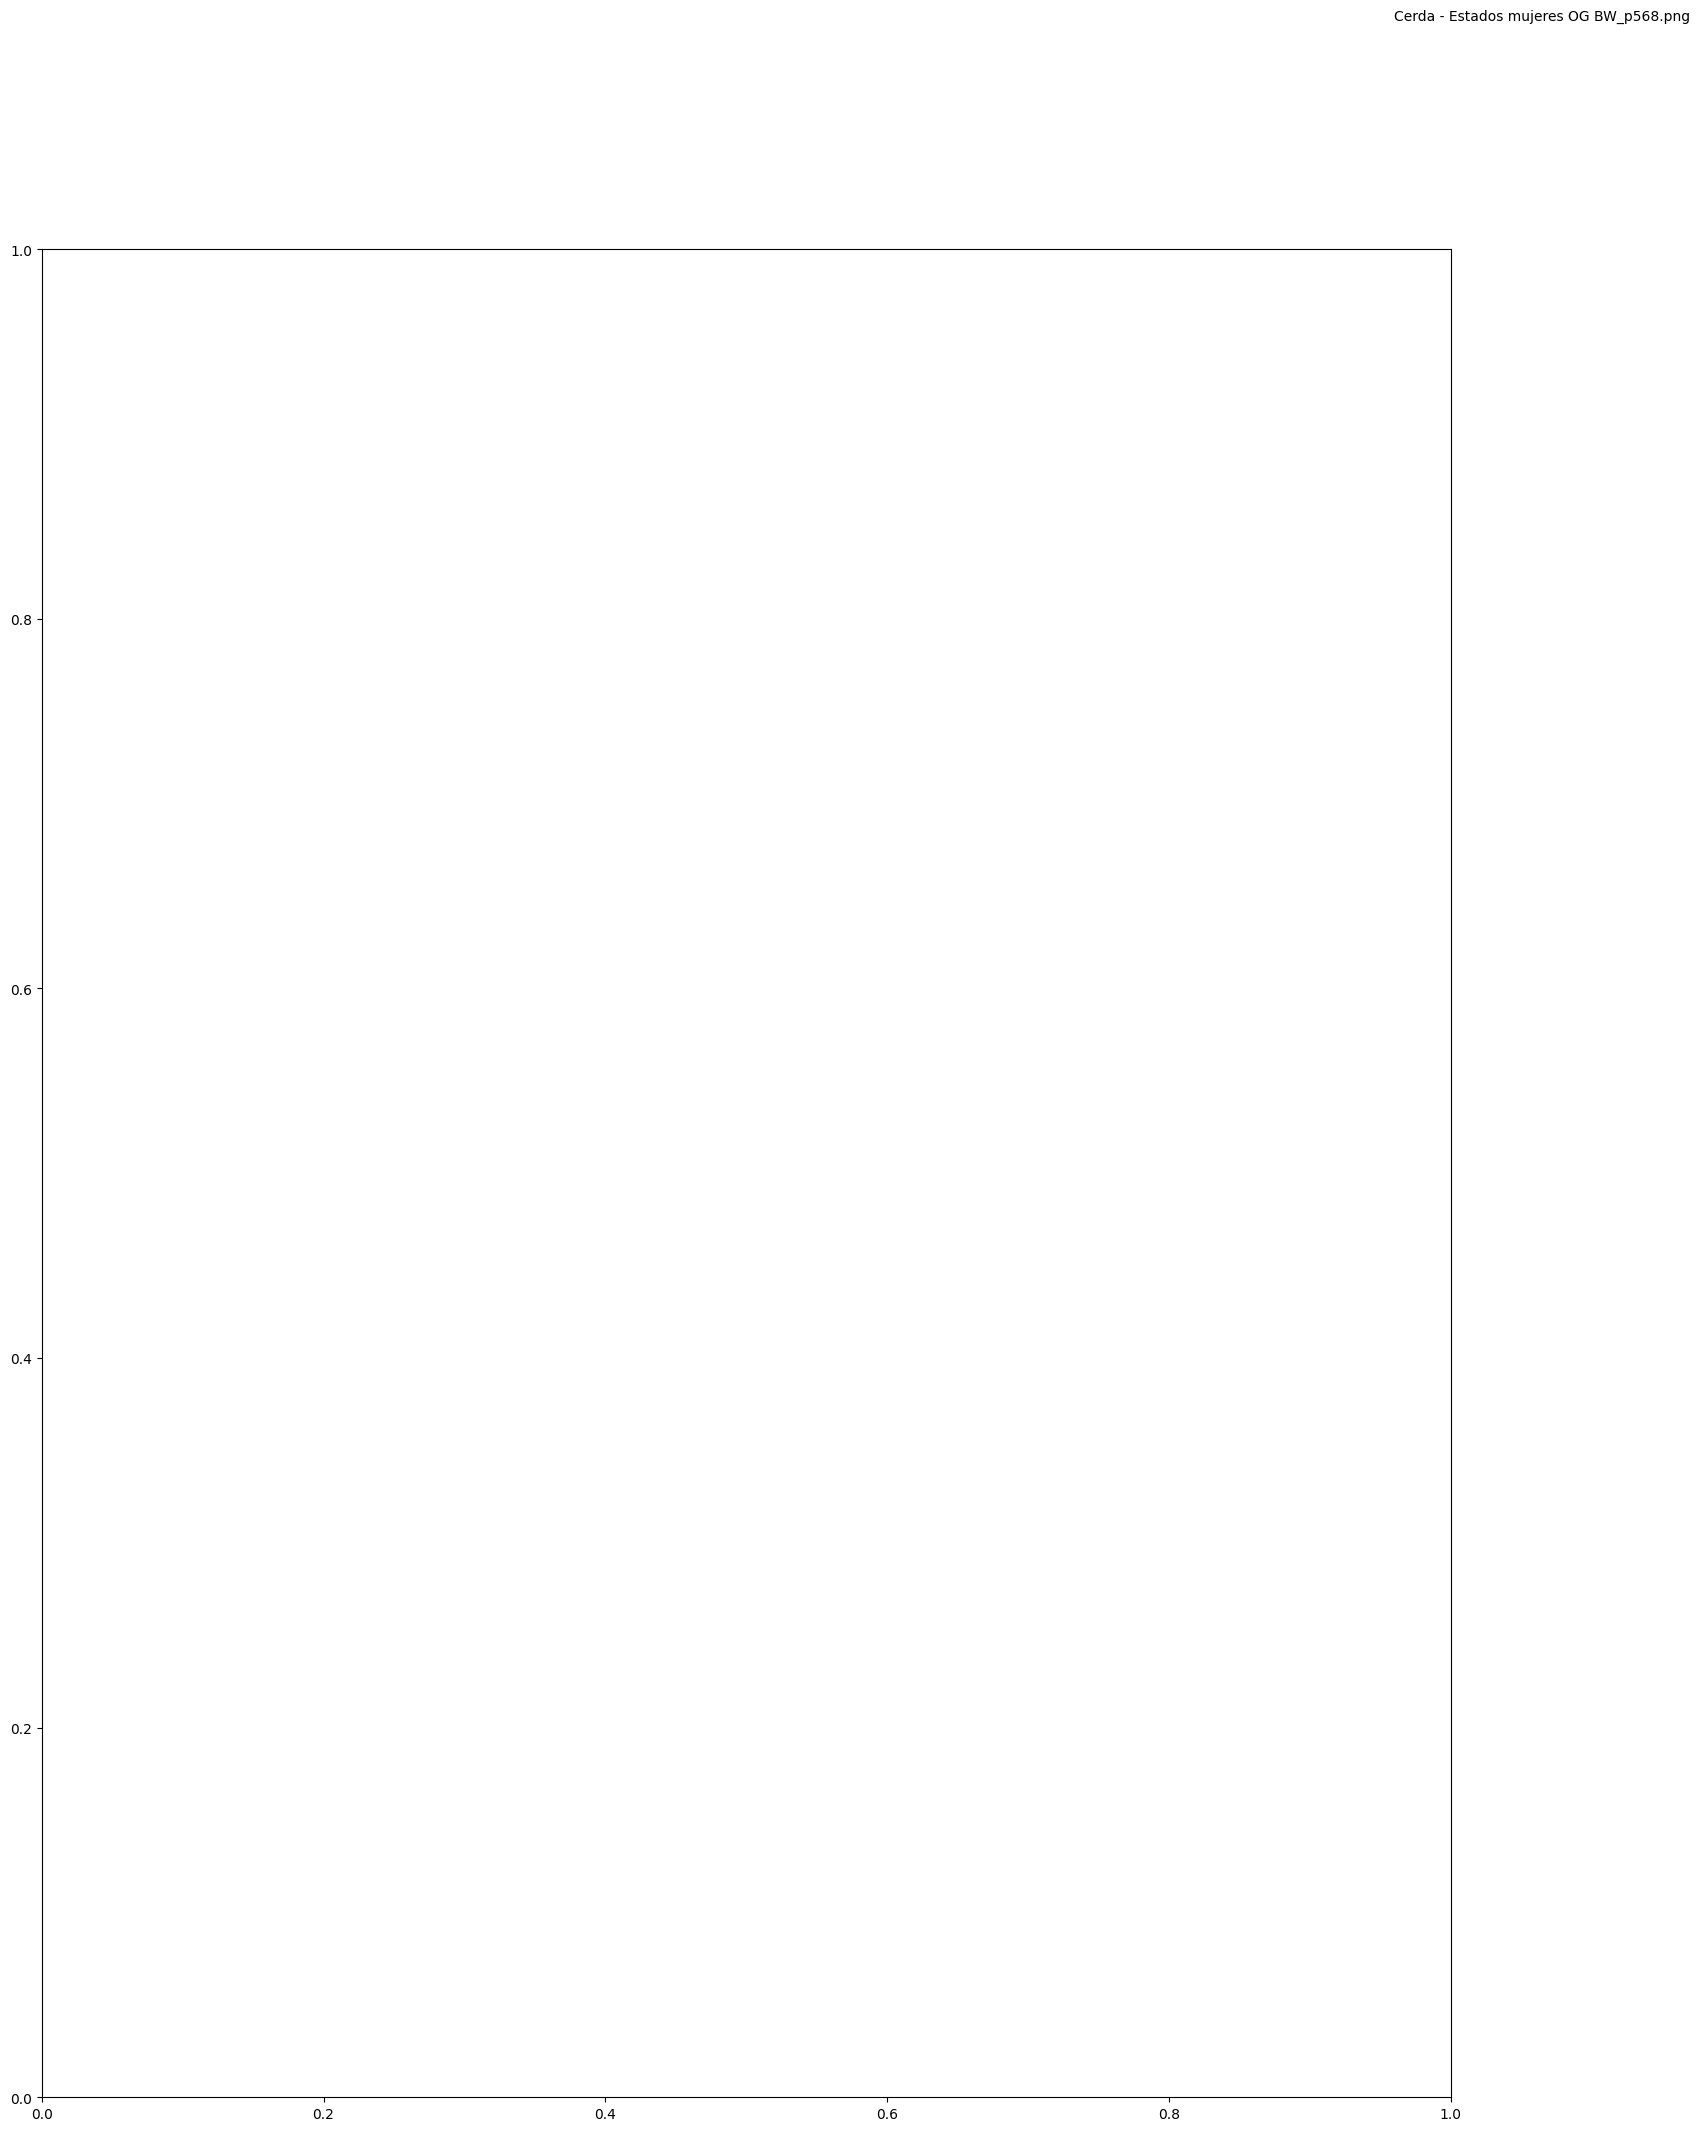

In [97]:
# Preview a Sample of Processed PNGs

import os
import random
import cv2
import matplotlib.pyplot as plt

# Directory containing your processed PNGs
processed_dir = r'c:\data\processed_data'

# Get all PNG filenames
png_files = [f for f in os.listdir(processed_dir) if f.lower().endswith('.png')]

# Sample up to 6 files (or fewer if less available)
sample_files = random.sample(png_files, min(6, len(png_files)))

for fname in sample_files:
    orig_path = os.path.join(png_dir, fname)
    proc_path = os.path.join(processed_dir, fname)

    orig = cv2.imread(orig_path, cv2.IMREAD_COLOR)
    proc = None
    if os.path.exists(proc_path):
        proc = cv2.imread(proc_path, cv2.IMREAD_GRAYSCALE)
# Plot side-by-side
    plt.figure(figsize=(40, 24))
    plt.suptitle(fname, fontsize=10)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(proc, cmap='gray')
    plt.title("Processed")
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
import os
import cv2
from pathlib import Path

def resize_all_pngs(input_dir, output_dir, max_side=1280):
    """
    Resize all .png images in input_dir so that the longest side is max_side,
    and save them to output_dir with the same filename.
    
    Parameters:
        input_dir (str): Path to folder containing PNG images.
        output_dir (str): Path to folder where resized images will be saved.
        max_side (int): Max width or height in pixels. Default is 1280.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    png_files = list(input_dir.glob("*.png"))

    for image_path in png_files:
        img = cv2.imread(str(image_path))
        if img is None:
            print(f"Could not read: {image_path}")
            continue

        h, w = img.shape[:2]
        scale = min(max_side / h, max_side / w)
        if scale >= 1.0:
            resized = img  # don't upscale
        else:
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        output_path = output_dir / image_path.name
        cv2.imwrite(str(output_path), resized)
        print(f"Resized: {image_path.name} → {output_path.name} ({resized.shape[1]}x{resized.shape[0]})")

    print(f"\nFinished resizing {len(png_files)} image(s). Resized images saved to: {output_dir}")

resize_all_pngs(processed_dir, processed_resized_dir, max_side=1280)
